In [1]:
import os
import torch
import torchvision
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

# Special imports of above dependencies:
import torchvision.transforms as T
import torch.nn.functional as F

# 4.3: Cleaning the dataset

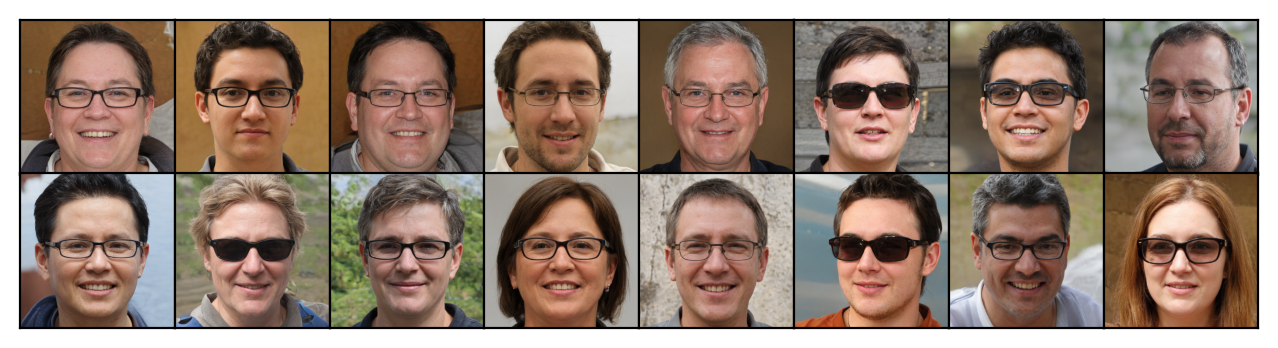

In [2]:
wGlasses = "../data/processed/glasses-no-glasses/wGlasses/" # Images with glasses
woGlasses = "../data/processed/glasses-no-glasses/woGlasses/" # Images without glasses

imgs_wG = os.listdir(wGlasses) # List all images with glasses
imgs_woG = os.listdir(woGlasses) # List all images without glasses

random.seed(42) # Set seed for reproducibility

# Plot images with glasses:
samples_wG = random.sample(imgs_wG, 16) # Randomly sample 16 images

fig = plt.figure(dpi=200, figsize=(8, 2)) # Create a figure with specified dpi and size

for i in range(len(samples_wG)):
    ax = plt.subplot(2, 8, i + 1) # Create a subplot in a 2x8 grid
    img = Image.open(f"{wGlasses}{samples_wG[i]}")
    plt.imshow(img) # Display the image
    plt.xticks([]) # Remove x-axis ticks
    plt.yticks([]) # Remove y-axis ticks

plt.subplots_adjust(wspace=-0.01, hspace=-0.01) # Adjust spacing between subplots
plt.show() # Show the figure

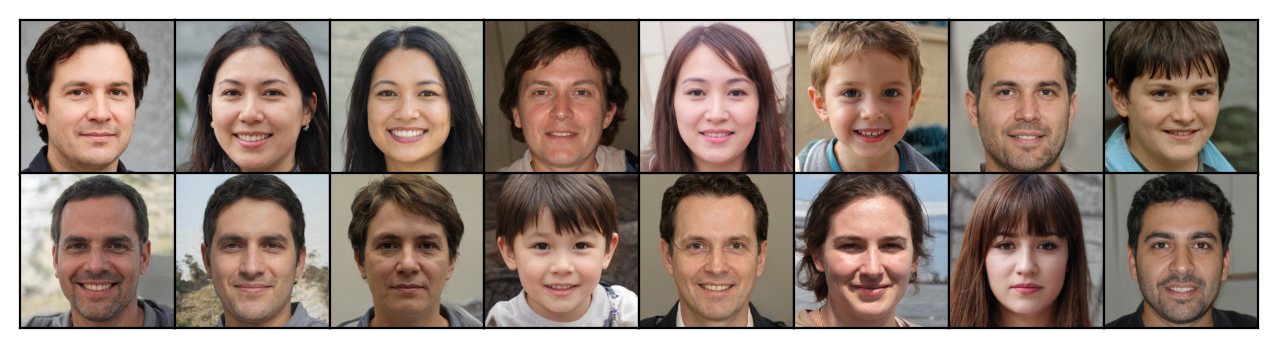

In [3]:
# Plot images without glasses:
samples_woG = random.sample(imgs_woG, 16) # Randomly sample 16 images

fig = plt.figure(dpi=200, figsize=(8, 2)) # Create a figure with specified dpi and size

for i in range(len(samples_woG)):
    ax = plt.subplot(2, 8, i + 1) # Create a subplot in a 2x8 grid
    img = Image.open(f"{woGlasses}{samples_woG[i]}")
    plt.imshow(img) # Display the image
    plt.xticks([]) # Remove x-axis ticks
    plt.yticks([]) # Remove y-axis ticks

plt.subplots_adjust(wspace=-0.01, hspace=-0.01) # Adjust spacing between subplots
plt.show() # Show the figure

# 4.4: Training the a VAE model

In [4]:
transform = T.Compose([T.Resize(256), T.ToTensor()]) # Transforming the data into tensors of 256x256 with normalized pixes [0.0 - 1.0]

data = torchvision.datasets.ImageFolder(root="../data/processed/glasses-no-glasses", transform=transform)

batch_size = 16
loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True) # Creating batches of images

In [5]:
# Detecting if a GPU is available:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device used: {torch.cuda.get_device_name(0)}") if device == "cuda" else print("No GPU available: Using CPU")

Device used: NVIDIA GeForce RTX 5080


In [6]:
latent_dims = 100 # Size of latent space

class Encoder(torch.nn.Module):
    def __init__(self, latent_dims=100):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 8, 3, stride=2, padding=1) # Input: 3x256x256 -> Output: 8x128x128
        self.conv2 = torch.nn.Conv2d(8, 16, 3, stride=2, padding=1) # Input: 8x128x128 -> Output: 16x64x64
        self.batch2 = torch.nn.BatchNorm2d(16) # Batch normalization layer
        self.conv3 = torch.nn.Conv2d(16, 32, 3, stride=2, padding=0) # Input: 16x64x64 -> Output: 32x31x31

        self.linear1 = torch.nn.Linear(31*31*32, 1024) # Fully connected layer

        # self.linear2 = torch.nn.Linear(1024, latent_dims) # Fully connected layer for mean
        # self.linear3 = torch.nn.Linear(1024, latent_dims) # Fully connected layer for log variance

        self.linear_mu = torch.nn.Linear(1024, latent_dims) # Fully connected layer for mean
        self.linear_log_var = torch.nn.Linear(1024, latent_dims) # Fully connected layer for log variance

        self.N = torch.distributions.Normal(0, 1) # Standard normal distribution
        self.N.loc = self.N.loc.cuda() # Move to GPU if available
        self.N.scale = self.N.scale.cuda() # Move to GPU if available

    def forward(self, x):
        x = x.to(device) # Move input to device (GPU or CPU)
        x = F.relu(self.conv1(x)) # Apply first convolutional layer and ReLU activation
        x = F.relu(self.batch2(self.conv2(x))) # Apply second convolutional layer, batch normalization, and ReLU activation
        x = F.relu(self.conv3(x)) # Apply third convolutional layer and ReLU activation

        x = torch.flatten(x, start_dim=1) # Flatten the output for the fully connected layers
        x = F.relu(self.linear1(x)) # Apply first fully connected layer and ReLU activation
        
        #mu = self.linear2(x) # Compute mean
        mu = self.linear_mu(x) # Compute mean
        log_var = self.linear_log_var(x) # Compute log variance

        #std = torch.exp(self.linear3(x)) # Compute standard deviation
        #z = mu + std*self.N.sample(mu.shape) # Reparameterization trick
        
        #return mu, std, z # Return mean, standard deviation, and latent variable
        return mu, log_var

In [7]:
class Decoder(torch.nn.Module):
    def __init__(self, latent_dims=100):
        super().__init__()
        self.decoder_lin = torch.nn.Sequential(
            torch.nn.Linear(latent_dims, 1024), # Fully connected layer
            torch.nn.ReLU(True), # ReLU activation
            torch.nn.Linear(1024, 31*31*32), # Fully connected layer to match the flattened size before conv layers
            torch.nn.ReLU(True)) # ReLU activation

        self.unflatten = torch.nn.Unflatten(dim=1, unflattened_size=(32, 31, 31)) # Unflatten layer to reshape the tensor
        self.decoder_conv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1), # Transposed convolutional layer
            torch.nn.BatchNorm2d(16), # Batch normalization layer
            torch.nn.ReLU(True), # ReLU activation
            torch.nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), # Transposed convolutional layer
            torch.nn.BatchNorm2d(8), # Batch normalization layer
            torch.nn.ReLU(True), # ReLU activation
            torch.nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1)) # Transposed convolutional layer
        
    def forward(self, x):
        x = self.decoder_lin(x) # Pass through fully connected layers
        x = self.unflatten(x) # Reshape the tensor
        x = self.decoder_conv(x) # Pass through transposed convolutional layers
        x = torch.sigmoid(x) # Ensure output is in [0, 1]

        return x

In [8]:
class VAE(torch.nn.Module):
    def __init__(self, latent_dims=100):
        super().__init__()
        self.encoder = Encoder(latent_dims) # Initialize encoder
        self.decoder = Decoder(latent_dims) # Initialize decoder

    ###### Calcular std de forma segura ######
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var) # Compute standard deviation from log variance
        eps = torch.randn_like(std) # Sample from standard normal distribution

        return mu + eps * std # Reparameterization trick

    def forward(self, x):
        x = x.to(device) # Move input to device (GPU or CPU)
        #mu, std, z = self.encoder(x) # Encode input to latent space
        mu, log_var = self.encoder(x) # Encode input to latent space
        z = self.reparameterize(mu, log_var) # Reparameterization trick

        return self.decoder(z), mu, log_var # Decode latent variable back to input space

In [9]:
# initialize the VAE model and move it to the appropriate device:
vae = VAE().to(device)
lr = 1e-4 # Learning rate
optiomizer = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5) # Adam optimizer

In [10]:
# Define the training epoch function:
def train_epoch(epoch):
    vae.train()
    epoch_loss = 0 # This will accumulate the loss over the epoch

    for imgs, _ in loader:
        imgs = imgs.to(device) # Move images to device (GPU or CPU)
        #mu, std, out = vae(imgs) # Forward pass through the VAE
        recon_imgs, mu, log_var = vae(imgs) # Forward pass through the VAE

        #reconstruction_loss = ((imgs - out) ** 2).sum() # Mean Squared Error loss
        reconstruction_loss = F.mse_loss(recon_imgs, imgs, reduction='sum') # Mean Squared Error loss

        #k1 = ((std ** 2)/2 + (mu ** 2)/2 - torch.log(std) - 0.5).sum() # KL Divergence
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) # KL Divergence
        loss = reconstruction_loss + kl_div # Total loss
        optiomizer.zero_grad() # Zero the gradients
        loss.backward() # Backpropagation
        optiomizer.step() # Update the weights
        epoch_loss += loss.item() # Accumulate loss
    
    print(f"At epoch {epoch}, loss is {epoch_loss}")

In [11]:
# Defininf plot funcion for reconstructions:
def plot_epoch():
    with torch.no_grad():
        noise = torch.randn(18, latent_dims).to(device) # Generate random noise in latent space
        imgs = vae.decoder(noise).cpu() # Decode the noise to generate images and move to CPU
        imgs = torchvision.utils.make_grid(imgs, 6, 3).numpy() # Arrange images in a grid

        fig, ax = plt.subplots(figsize=(6,3), dpi=100)
        plt.imshow(np.transpose(imgs, (1, 2, 0)))
        plt.axis("off")
        plt.show()

In [ ]:
# ==========================================================================
# ####### MODEL TRAINING (EXCECUTE ONLY IF RE-TRAINING IS NECESSARY) #######
# ==========================================================================p

# nEpochs = 11

# for epoch in range(nEpochs):
#     train_epoch(epoch) # Train for one epoch
#     plot_epoch() # Plot reconstructions after each epoch

# # Saving the trained model:
# torch.save(vae.state_dict(), "../models/vae_glasses.pth") # Save the model state dictionary

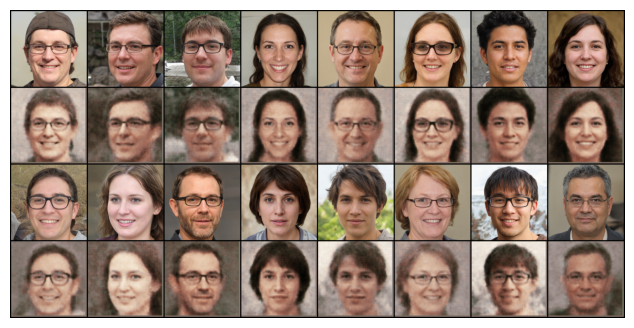

In [13]:
# Generating images using the trained model:

vae.eval() # Set the model to evaluation mode

with torch.no_grad(): # Disable gradient calculation

	vae.load_state_dict(torch.load("../models/vae_glasses.pth", map_location=device)) # Load the trained model
	imgs, _= next(iter(loader)) # Get a batch of images
	imgs = imgs.to(device) # Move images to device (GPU or CPU)
	recon_imgs, mu, log_var = vae(imgs) # Forward pass through the VAE

	# Concatenate original and reconstructed images and move to CPU
	images = torch.cat([
		imgs[:8].detach().cpu(), 
		recon_imgs[:8].detach().cpu(), 
		imgs[8:16].detach().cpu(), 
		recon_imgs[8:16].detach().cpu()
	], dim=0)
	images = torchvision.utils.make_grid(images, 8, 4)
	fig, ax = plt.subplots(figsize=(8,4), dpi=100)
	plt.imshow(np.transpose(images.numpy(), (1, 2, 0)))
	plt.axis("off")
	plt.show()

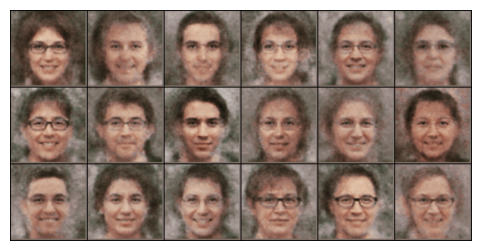

In [14]:
plot_epoch()

# 4.5: Encoding Arithmetic with VAE

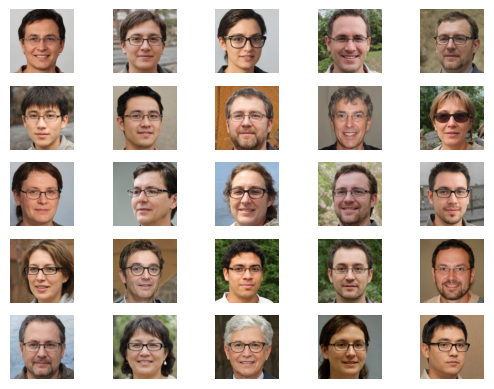

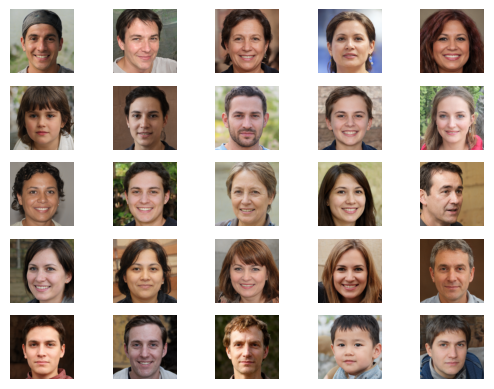

In [19]:
torch.manual_seed(0)
glasses = []

for i in range(25): # Get 25 images with glasses
    img, label = data[i]
    glasses.append(img)
    
    plt.subplot(5, 5, i+1)
    plt.imshow(img.numpy().transpose((1, 2, 0)))
    plt.axis('off')

plt.show()

men_g = [glasses[0], glasses[3], glasses[14]] # Select specific images for men with glasses
women_g = [glasses[9], glasses[15], glasses[21]] # Select specific images for women with glasses

noglasses = []
for i in range(25): # Get 25 images without glasses
    img, label = data[-i-1]
    noglasses.append(img)
    
    plt.subplot(5, 5, i+1)
    plt.imshow(img.numpy().transpose((1, 2, 0)))
    plt.axis('off')

plt.show()

men_ng = [noglasses[1], noglasses[7], noglasses[22]] # Select specific images for men without glasses
women_ng = [noglasses[4], noglasses[9], noglasses[18]] # Select specific images for women without glasses

In [24]:
# Create a batch of images for every category - stack is better than concat and unsqueeze for this purpose
men_g_batch     = torch.stack(men_g).to(device) # Men with glasses
women_g_batch   = torch.stack(women_g).to(device) # Women with glasses
men_ng_batch    = torch.stack(men_ng).to(device) # Men without glasses
women_ng_batch  = torch.stack(women_ng).to(device) # Women without glasses

vae.eval() # Set the model to evaluation mode

with torch.no_grad(): # Disable gradient calculation
    
    # Obtain the distribution parameters for the three images - We only need the mean for this operation, so we ignore the log variance:
    men_g_mu, _     = vae.encoder(men_g_batch) # Men with glasses distribution parameters
    women_g_mu, _   = vae.encoder(women_g_batch) # Women with glasses distribution parameters
    men_ng_mu, _    = vae.encoder(men_ng_batch) # Men without glasses distribution parameters
    women_ng_mu, _  = vae.encoder(women_ng_batch) # Women without glasses distribution parameters 

    # Average the mu vectors to get the prototype of "men|women with|without glasses" encoding:
    men_g_encoding      = men_g_mu.mean(dim=0) # Mean encoding for men with glasses
    women_g_encoding    = women_g_mu.mean(dim=0) # Mean encoding for women with glasses
    men_ng_encoding     = men_ng_mu.mean(dim=0) # Mean encoding for men without glasses
    women_ng_encoding   = women_ng_mu.mean(dim=0) # Mean encoding for women without glasses

    #Decode the mean encoding to create the image prototype:
    men_g_recon = vae.decoder(men_g_encoding.unsqueeze(0)) # Unsqueeze to add batch dimension of 1 for the decoder
    women_w_recon = vae.decoder(women_g_encoding.unsqueeze(0))
    men_ng_recon = vae.decoder(men_ng_encoding.unsqueeze(0))
    women_ng_recon = vae.decoder(women_ng_encoding.unsqueeze(0))


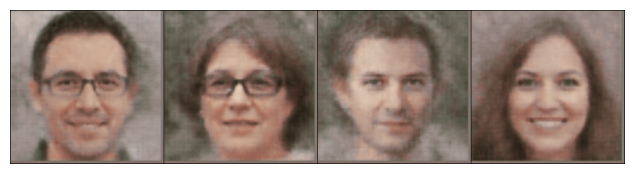

In [ ]:
# Generating new images by sampling from the latent space:
imgs = torch.cat((men_g_recon, women_w_recon, men_ng_recon, women_ng_recon), dim=0)
imgs = torchvision.utils.make_grid(imgs, 4, 1).cpu().numpy()
imgs = np.transpose(imgs, (1, 2, 0)) # Change from (C, H, W) to (H, W, C)

fix, ax = plt.subplots(figsize=(8, 2), dpi=100)
plt.imshow(imgs)
plt.axis("off")
plt.show()

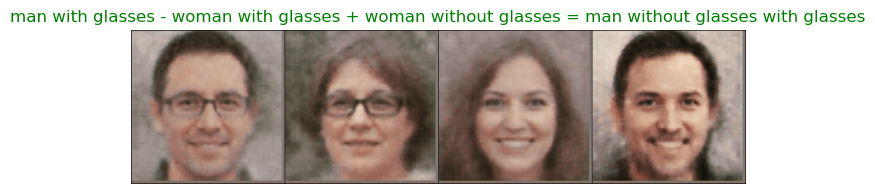

In [28]:
# Vector arithmetic in the latent space:
z = men_g_encoding - women_g_encoding + women_ng_encoding # Vector arithmetic in latent space
out = vae.decoder(z.unsqueeze(0)) # Decode the new latent vector

imgs = torch.cat((men_g_recon, women_w_recon, women_ng_recon, out), dim=0) # Concatenate the images
imgs = torchvision.utils.make_grid(imgs, 4, 1).cpu().numpy()
imgs = np.transpose(imgs, (1, 2, 0)) # Change from (C, H, W) to (H, W, C)

fig, ax = plt.subplots(figsize=(8, 2), dpi=100)
plt.imshow(imgs)
plt.title("man with glasses - woman with glasses + woman without glasses = man without glasses with glasses", c="g")
plt.axis("off")
plt.show()

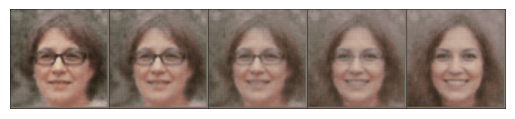

In [32]:
# Interpolating:
results = []

for w in np.arange(0.0, 1.0, 0.2):
    z = w*women_ng_encoding + (1-w)*women_g_encoding # Linear interpolation
    out = vae.decoder(z.unsqueeze(0)) # Decode the interpolated latent vector
    results.append(out.squeeze(0).cpu()) # Append the result to the list

imgs = torch.stack(results) # Stack the results into a single tensor
imgs = torchvision.utils.make_grid(imgs, 6, 1).cpu().numpy() # Create a grid of images
imgs = np.transpose(imgs, (1, 2, 0)) # Change from (C, H, W) to (H, W, C)

fix, ax = plt.subplots(dpi=100)
plt.imshow(imgs)
plt.axis("off")
plt.show()